# Students
- Gabriele Bellavia \[matric.num]
- Luigi Belli - 2152859
- Margherita Lera - 2142875
- Giovanni Andrea Maida - 2159404

# Gradient descent & Deep Neural Networks




From here we start the execution of the assigned task.
We construct the neural net using Sequential() from Keras, called **model**, that allows to build the NN layer by layer. We add 3 layers each of 20 units using Dense().

In the same function we implement a random search using the package Keras Tuner. Random search is a family of optimization methods that do not require the gradient fo the optimization problem. This method is generally used, and also by us, for hyper-parameter optimization.

We optimized the following hyper-parameters searching through the associated options:
- Optimizer: {adam, Nesterov, RMSprop, adamax, adagrad}
- Non-linear activation function : {sigmoid, Relu, elu}
- Dropout value: {0.0, 0.1, 0.2}
- Learning rate: {$10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}$}

Let's dive deeper into what these are.

Optimization algorithms are meant to reduce loss acting on weights of the neural network. We tried the following types:
- Stochastic Gradient Descent with Nesterov Momentum, basically the gradient descent is an algorythm that follows the negative gradient of a function to locate the minimum, while momentum is an approach that accelerates the progress of the search to get over flat areas. The Nesterov momentum is an extension of momentum that involves computing the partial derivative of the projected update rhater thatn the derivative of the current variable value. It handles better saddle point, reduce oscillations and should lead to faster convergence.
- RMSprop keeps a moving average of the squared gradients for each weight of the model, adapts the learning rate based on said average, normalizes the gradients to avoid too big or too small values.
- Adam (adaptive moment estimation) combines the ideas of momentum and RMSprop. Is effective in handling noisy data and it adapts the learning rate for each parameter, leading to faster convergence
- Adamax is a variant of Adam, it modifies how the learning rate is adapted to each parameter, here is adapted based on the infinity norm, which is the maximum absolute value of the gradient.
- Adagrad is a variation of Adam that accumulates the sum of squared past gradients, making the learning rate to decrease continuously, works for sparse data.

Activation functions are applied to the output of a neuron and it determines if the neuron should be turned on or off. This introduces non-linearity on the model so it can learn complex patterns. We picked all non-linear activation functions.

Dropout is a regulatization technique that prevents overfitting by random setting a fraction of neurons to zero during the training.


Constructing a Deep Neural Network to solve ML problems can be syntesized on following key-steps [Mehta]{\[Mehta et al.\]}:

1. Load and process the data
2. Define the model and its architecture
3. Choose the optimizer and the cost function
4. Train the model
5. Evaluate the model performance on the unseen test data
6. Modify the hyperparameters to optimize performance for the specific data set

Step 1 is given with the problem's environment while steps 2 to 6 can be automatized using Random Search method.

For any NN, , it is necessary to tune hyper-parameters such as the ones mentioned above, but finding the best combinations of them could be a lenghty and expensive process. There are two main approaches.
- Grid Search, that tries out all the possible combinations of hyperparameters in a predefined grid.
- Random Search instead picks samples randomly from the hyperparameter space, previously defined. This approach is less computationally expensive because it explores a random subset of hyper-parameters space.

We will implement the latter:

In [3]:
import numpy as np

import os
import json
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner
from kerastuner.engine.trial import Trial
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler

rng = np.random.default_rng(1758)

plt.rcParams['font.size'] = 13



%run useful.py

In [16]:

### We edited the class RandomaSearch to be able to plot scores of each trials ###############################
class RandomSearch(keras_tuner.RandomSearch):
    histories = {}

    def on_epoch_end(self, trial, model, epoch, logs=None):
        trial_id = trial.trial_id
        trial_history = self.histories.setdefault(trial_id, {})
        for metric, value in logs.items(): trial_history.setdefault(metric, []).append(value)

    def on_trial_end(self, trial):
        super().on_trial_end(trial)

        self.plot_and_save_history(trial)

    def plot_and_save_history(self, trial: Trial):
        trial_id = trial.trial_id
        trial_history = self.histories[trial_id]

        # Create directory for trial if it doesn't exist
        trial_dir = self.get_trial_dir(trial_id)
        os.makedirs(trial_dir, exist_ok=True)

        # Save history to JSON file
        history_file = os.path.join(trial_dir, "history.json")
        with open(history_file, "w") as f:
            json.dump(trial_history, f, indent=4)

    def plot_best_trials(self, num_models=5, wrap_columns=4, smooth_factor=0.5, figure_size=(20,5), suffix=""):
        best_trials = self.oracle.get_best_trials(num_models)
        num_trials = len(best_trials)

        rows = (num_trials - 1) // wrap_columns + 1
        cols = min(num_trials, wrap_columns)

        fig, axes = plt.subplots(rows, cols, figsize=figure_size, layout='constrained')

        for i, trial in enumerate(best_trials):
            trial_id = trial.trial_id
            trial_dir = self.get_trial_dir(trial_id)
            history_file = os.path.join(trial_dir, "history.json")

            with open(history_file, "r") as f:
                trial_history = json.load(f)

            ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
            for metric_name, metric_values in trial_history.items():
                smoothed_values = self.smooth_values(metric_values, smooth_factor)
                ax.plot(smoothed_values, label=f"{metric_name}")

            ax.set_title(f"Trial {trial_id}")
            ax.set_xlabel("Step")
            ax.set_ylabel("Value")
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
            ax.set_xlim(0, 400)
            ax.legend(fontsize=9)

    def plot_worst_trials()
        

    def smooth_values(self, values, smooth_factor):
        """
        Smooth values with moving average
        In this example implementation, the smooth_values method takes in a list of values and a smooth_factor between 0 and 1.
        It first checks if the smooth_factor is within the valid range (0 to 1). If it's not, it returns the original values without any smoothing.
        Next, it calculates the number of smoothed values based on the smooth_factor.
        It then iterates over the values list, applying the simple moving average (SMA) technique to calculate the smoothed value at each index.
        The number of values used for the moving average calculation increases gradually until it reaches the desired number of smoothed values.
        After that, a fixed window size is used for calculating the moving average.
        # Code generated by chatgpt
        """
        if smooth_factor <= 0.0 or smooth_factor >= 1.0:
            return values

        num_values = len(values)
        num_smoothed_values = int(num_values * (1 - smooth_factor)) + 1
        smoothed_values = []

        for i in range(num_smoothed_values):
            start_index = max(0, i - num_smoothed_values + 1)
            end_index = i + 1
            subset = values[start_index:end_index]
            smoothed_value = sum(subset) / len(subset)
            smoothed_values.append(smoothed_value)

        for i in range(num_smoothed_values, num_values):
            start_index = i - num_smoothed_values + 1
            end_index = i + 1
            subset = values[start_index:end_index]
            smoothed_value = sum(subset) / num_smoothed_values
            smoothed_values.append(smoothed_value)

        return smoothed_values
    
    
###### END of editing the RandomSearch() class. #################

## Read data

In [5]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8
# span of each component
B=10
perc_train = 0.8
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)

N_train = int(perc_train * N)

## Standardize data

In [6]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Split training and test data

In [7]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_test, y_test) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Test:",len(x_test))

Train: 1600 	 Test: 400


## 1) Random Search of best hyperparameters

## Define the model with Keras / Tensorflow

In [8]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(L, input_shape=(L,), activation='relu'))
    hidd_active = hp.Choice('hidd_activation', ['sigmoid','relu','elu'])
    
    # 3 hidden layers
    for layer_num in range(1, 4):
        model.add(Dense(20, activation=hidd_active))
        model.add(Dropout(hp.Float(f'Dropout_{layer_num}', min_value=0, max_value=0.2, step=0.1)))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    learning_rate = hp.Choice('lr', [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
    hyper_optimizer = hp.Choice('optimizer', ['adam', 'sgd_nesterov', 'RMSprop', 'adamax', 'adagrad'])

    # Define sgd_nesterov
    if hyper_optimizer == 'sgd_nesterov': hyper_optimizer = SGD(learning_rate=learning_rate, nesterov=True)
        
    model.compile(loss='binary_crossentropy', optimizer=hyper_optimizer, metrics=["accuracy"])
    return model


build_model(keras_tuner.HyperParameters()) # Construction of the model
tuner = keras_tuner.RandomSearch(hypermodel=build_model, 
                                 objective="val_accuracy", # parameter that evaluates the best perfoming epoch of trial, because validation accuracy does not
                                 ########################### behave monothnically, so we pick the best value.
                                 max_trials=15,  # 15 models, with random choices of hyperparameters
                                 executions_per_trial=2, # two trials in case of some errors, by limited ram or whatsoever.
                                 overwrite=True, #this to avoid to pick up old models of when we were trying to understand how everything worked.
                                 project_name='search'# directory where trials are saved.
                                ) # Calling the model, with some parameters as above described.
tuner.search(x_train[200:], 
             y_train[200:],
             epochs=400,  # 
             validation_data=(x_train[:200], y_train[:200])) #implementing the actual search

Trial 15 Complete [00h 00m 41s]
val_accuracy: 0.9649999737739563

Best val_accuracy So Far: 0.9649999737739563
Total elapsed time: 00h 10m 15s


In [9]:
tuner.results_summary(num_trials=5) # In our run, first five model had validation performance above 0.90, so we selected these.
models = tuner.get_best_models(num_models=5)  # Selecting the first 4 best models by accuracy

/home/teobaldo/anaconda3/envs/LCP/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/teobaldo/anaconda3/envs/LCP/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Results summary
Results in ./search
Showing 15 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.1
Dropout_2: 0.0
Dropout_3: 0.2
lr: 0.001
optimizer: RMSprop
Score: 0.9649999737739563

Trial 14 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.1
Dropout_2: 0.1
Dropout_3: 0.2
lr: 0.0001
optimizer: adam
Score: 0.9649999737739563

Trial 01 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.2
Dropout_2: 0.0
Dropout_3: 0.0
lr: 0.001
optimizer: adam
Score: 0.9599999785423279

Trial 12 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.1
Dropout_2: 0.2
Dropout_3: 0.0
lr: 0.001
optimizer: RMSprop
Score: 0.9599999785423279

Trial 04 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.1
Dropout_2: 0.0
Dropout_3: 0.1
lr: 0.0001
optimizer: adam
Score: 0.9549999833106995

Trial 03 summary
Hyperparameters:
hidd_activation: sigmoid
Dropout_1: 0.0
Dropout_2: 0.0
Dropout_3: 0.1
lr: 0.1
optimi

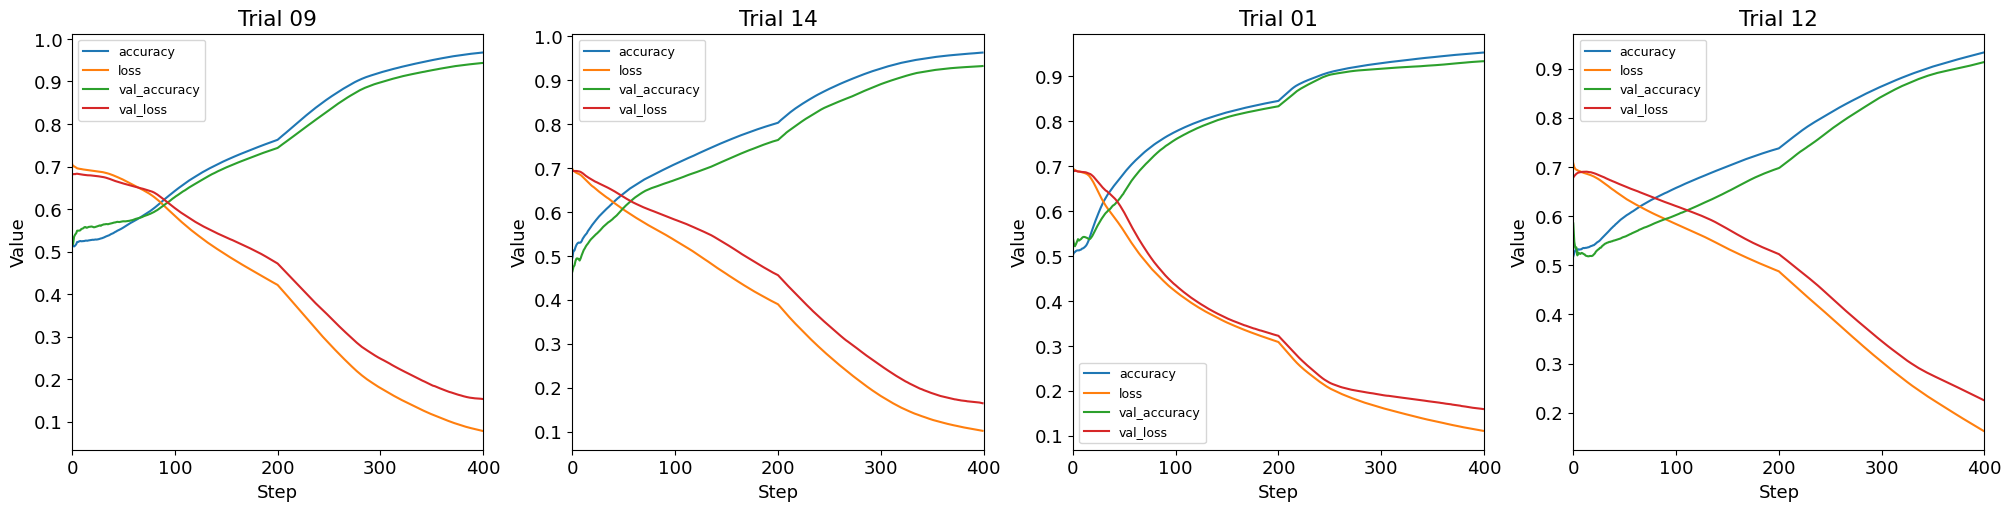

In [15]:
tuner.plot_best_trials(num_models=4) # Scores vs epoch of the best 4 models.
plt.show()

## Cross Validation

1
[(0.9856249928474426, 0.006434778332619843), (0.9924999952316285, 0.004238944287474007), (0.9774999976158142, 0.008477920212559532), (0.9837499976158142, 0.0041457968028436485)]


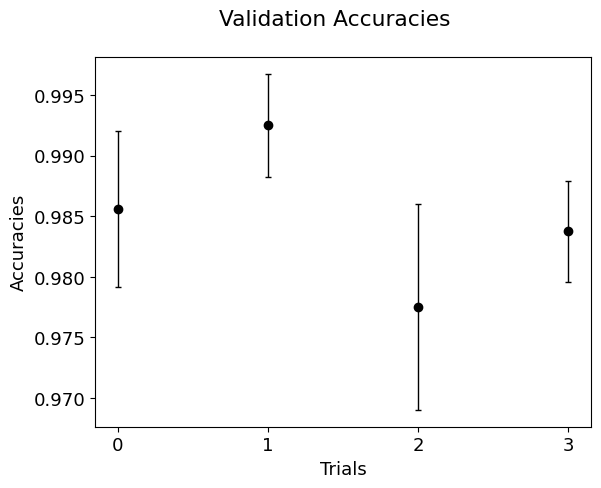

In [43]:
def k_fold_cross_validation(x_train, y_train, k, models):
     # Initialize holders
    best = -1 #best model, placeholder
    best_perf = -1 #best score, placeholder
    results = [] # Initialize list to store performance of each model
    best_num = -1 #index of the best model, placeholder
    stds = [] # Initializes standard deviations List
    # Divide training set in K folds
    idx = rng.permutation(np.arange(x_train.shape[0]))
    x_folds, y_folds = np.array_split(x_train[idx, :], k), np.array_split(y_train[idx], k)
    
    for i in range(len(models)):
        model_perf = []
        for test in range(k): #k-fold cross-validation
            x_train_fold = np.concatenate([x for i, x in enumerate(x_folds) if i != test])
            y_train_fold = np.concatenate([x for i, x in enumerate(y_folds) if i != test])
            # Above: concatenate training data for the current fold, excludes current testing fold
            ############################
            # Below: Set current fold as validation
            x_validate_fold, y_validate_fold = x_folds[test], y_folds[test]
            # Below: fit model on training and evaluate on validation fold.
            k_model = models[i].fit(x_train_fold, y_train_fold, verbose=0)
            # Accumulates the performance
            model_perf.append(models[i].evaluate(x_validate_fold, y_validate_fold, verbose=0)[1])        
        results.append(((curr_perf := np.mean(model_perf)), np.std(model_perf))) # Average and std over the k-folds
        # if the current model performs better than best, updates best__
        if (best_perf < curr_perf):
            best, best_num = models[i], i
            best_perf = curr_perf
        #Below: return best model, its index, and list of performance results for each model
    return best, best_num, results

best_model, which_best, results = k_fold_cross_validation(x_train, y_train, 5, models)
print(which_best) # Index of best model
print(results) #Performance of each model.

### FINCANTIERI ########################################
fig, ax = plt.subplots()
fig.suptitle('Validation Accuracies')
ax.errorbar(range(len(results)), [results[i][0] for i in range(len(results))], yerr=[results[i][1] for i in range(len(results))], fmt='ok', capsize=2, elinewidth=1)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_ylabel('Accuracies')
ax.set_xlabel('Trials')
plt.show()

## Training

In [18]:
fit = best_model.fit(x_train, y_train, batch_size = 50, validation_data=(x_test,y_test), verbose=0) # Training best model and evaluating it using the test dataset

We see in these graphs above that loss & accuracy for train data and validation data stays kind of static, this because thanks to Random Search method we already selected the best hyper parameter of the model. (Because of the size of the batch?????? TO bE continued)

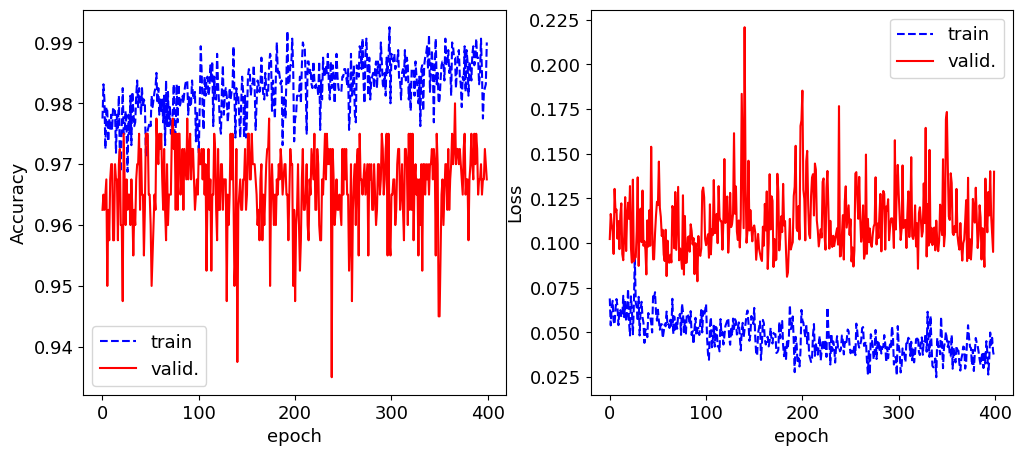

In [10]:
fig,AX=plt.subplots(1,2,figsize=(12,5.))
ax=AX[0]

ax.plot(fit.history['accuracy'],label="train",c="b",ls="--")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b",ls="--")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

## Grid to show preditions

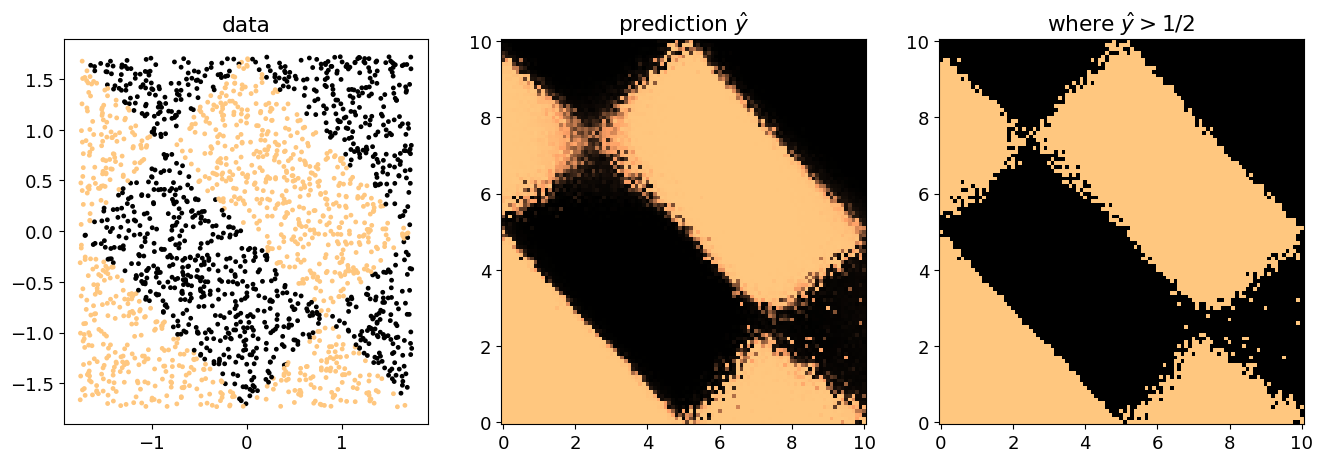

In [19]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = best_model.predict(grid_r, verbose=0)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
fig.suptitle('Results')
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()

## PART 2

4000
(4000, 8)


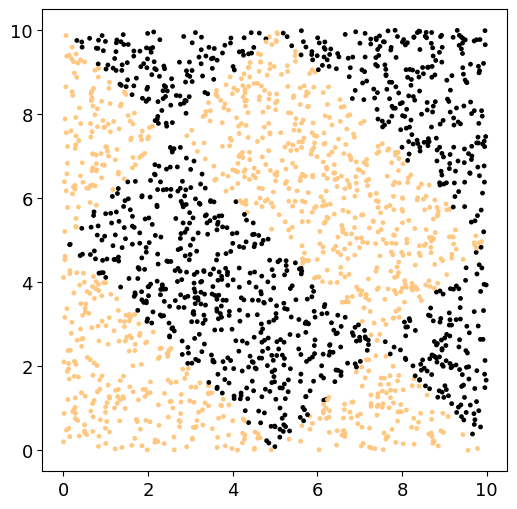

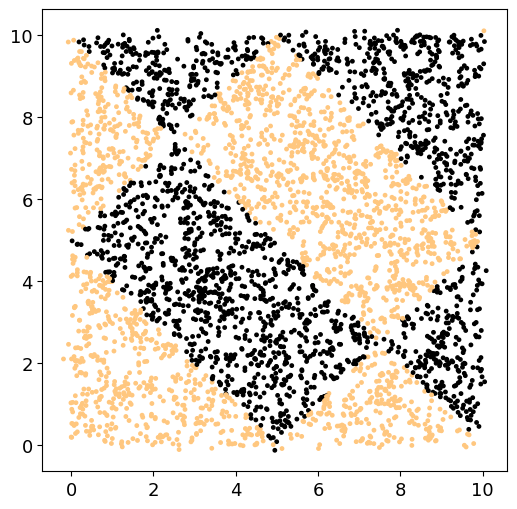

In [15]:
import random

TYPE=3
L=8
N_aug=9000
B=10

# ORIGINAL
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
#print(x.shape)
#print(y.shape)

# REDUCTED
index= random.sample(range(len(x)),int(0.5*x.shape[0]))
x_reducted = x[index]
y_reducted = y[index]
#plot_data(x_reducted,y_reducted)
x_reducted=np.array(x_reducted)
y_reducted=np.array(y_reducted)
#print(x_reducted.shape)
#print(y_reducted.shape)

# INCREASED
np.random.seed(1)
x_increased=np.random.random((N_aug,L))*B #number between (0,1) * width of data sample
y_increased=list(np.zeros(N_aug))
for i in range(N_aug):
    y_increased[i]=NF(x_increased[i],B,TYPE)
#plot_data(x_new,y_new)
y_increased=np.array(y_increased)
#print(x_increased.shape)
#print(y_increased.shape)

# AUGMENTED
x_augmented=np.loadtxt(filename("data",L,TYPE), delimiter=' ')
#distanza media sulla prima feature:
'''
x_sorted=sorted(x_augmented[:,0])
dist=[]
for i in range(1,N):
    dist.append(x_sorted[i]-x_sorted[i-1])
std=np.mean(dist)
'''
for i in range(0,N):
    lista=[]
    for j in range(L):
        lista.append(np.random.normal(loc=x[i,j],scale=0.1))
    x_augmented=np.append(x_augmented,[lista],axis=0)

y_augmented=list(np.zeros(x_augmented.shape[0]))
for i in range(x_augmented.shape[0]):
    y_augmented[i]=NF(x_augmented[i],B,TYPE)

print(len(y_augmented))
print(x_augmented.shape)
x_augmented=np.array(x_augmented)
y_augmented=np.array(y_augmented)
plot_data(x,y)
plot_data(x_augmented,y_augmented)




In [16]:
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss

def prepare_data(x,y):
    """
    Does rescaling and divides into training and test set.
    """
    perc_train=0.8
    N=len(x)
    N_train = int(perc_train * N)
    x_mean = np.mean(x,axis=0)
    x_std  = np.std(x,axis=0)
    #print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
    x = Standardize(x,x_mean,x_std)
    #print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))
    ## Split training and test data
    (x_train, y_train) = (x[0:N_train],y[0:N_train])
    (x_test, y_test) = (x[N_train:],y[N_train:])
    #print("Train:",len(x_train),"\t Validation:",len(x_valid))
    return x_train,y_train,x_test,y_test

In [ ]:
def train_data(X,Y):
    '''
    STO DANDO PER SCONTATO CHE SIA STATO TROVATO E RUNNATO IL BEST MODEL
    '''
    nepoch = 400 #CHANGE HERE FOR FASTER/SLOWER RUN 
    x_train,y_train,x_test,y_test=prepare_data(X,Y)
    fit = best_model.fit(x_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_test,y_test),
               verbose=0)
    
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],label="train",c="b",ls="--")
    ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],label="train",c="b",ls="--")
    ax.plot(fit.history['val_loss'],label="valid.",c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.legend()


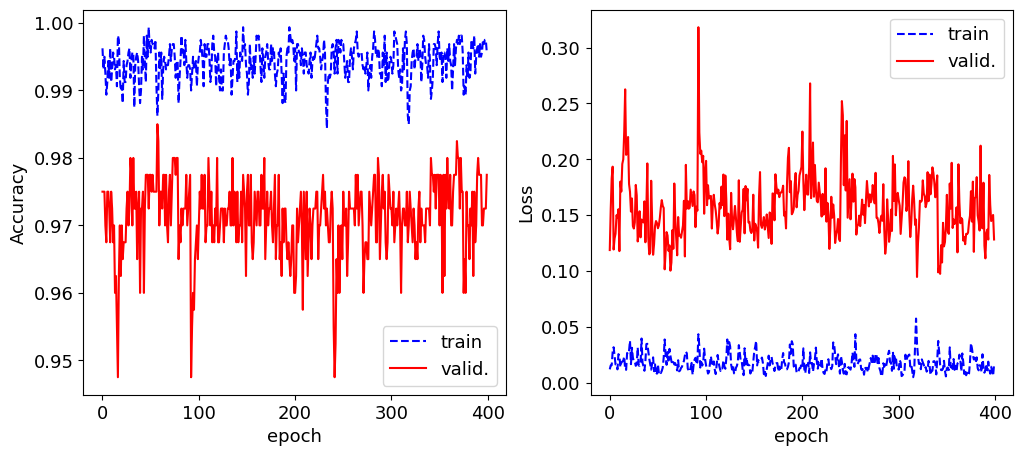

In [ ]:
train_data(x,y)


nel random search i primi tot del training set sono il validation data. Uso il test set solo nel fit del best model perchè il fit non si traina su quello ma nell'evaluate lo prende  e sputa fuori l'accuracy del train set e quella è la validation accuracy sul test set. 


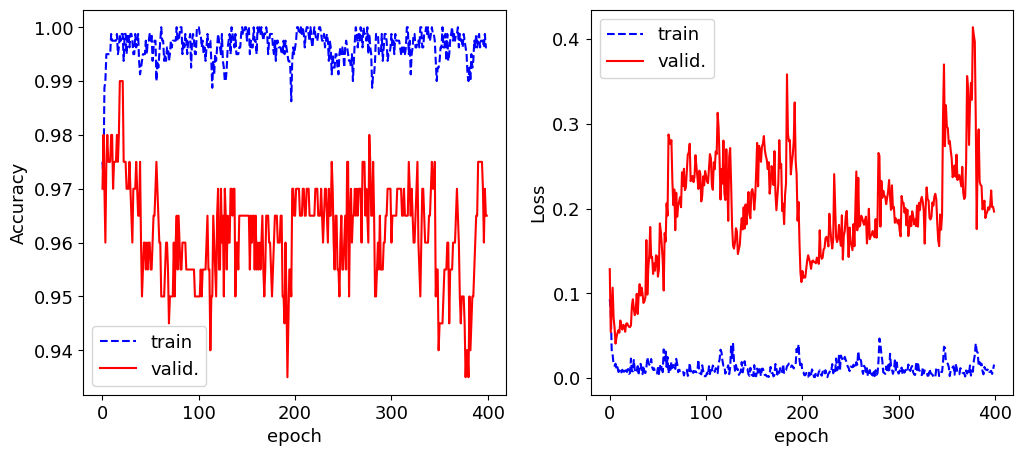

In [25]:
train_data(x_reducted,y_reducted)


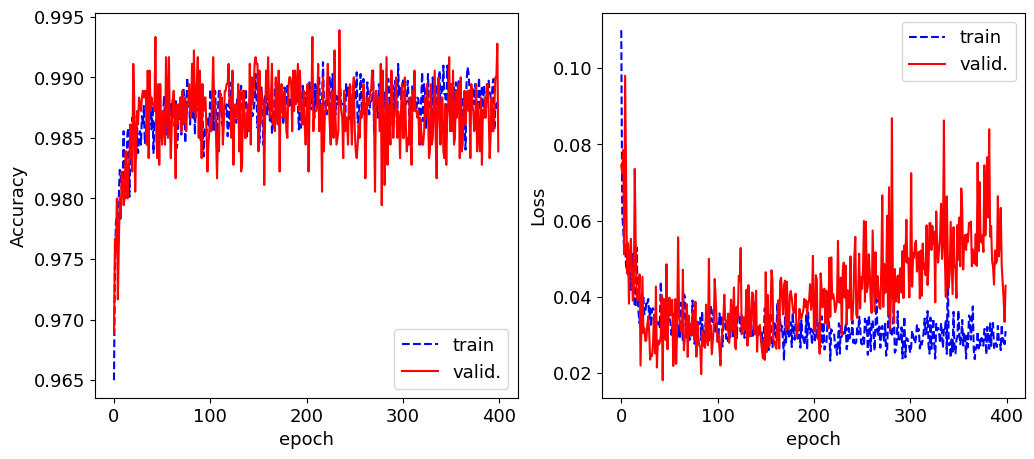

In [26]:
train_data(x_increased,y_increased)  


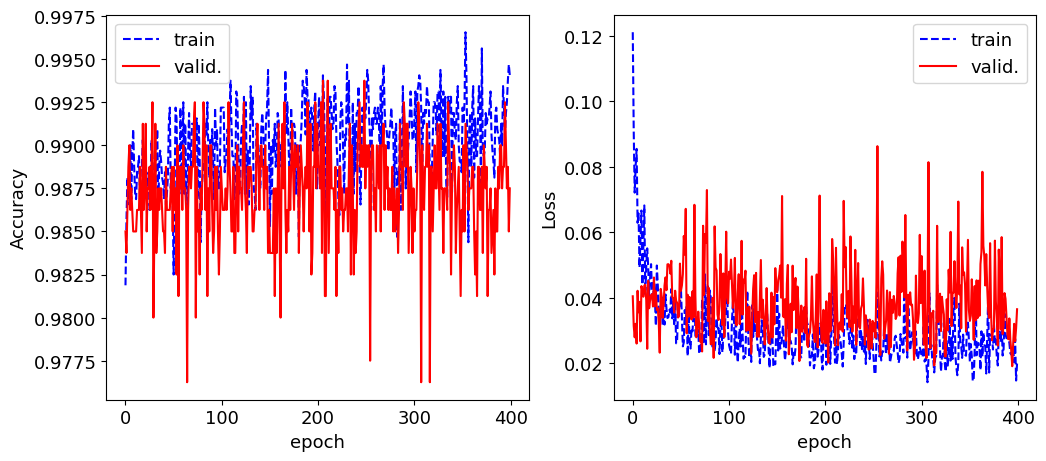

In [27]:
train_data(x_augmented,y_augmented)
